<a href="https://colab.research.google.com/github/atabakjd/JSE-Stock-Market-Returns-Prediction-Using-Multivariate-Time-Series-Data/blob/main/crypto_mvgruReg_yfinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this code uses yfinance to get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install yfinance
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import yahoofinancials
from math import sqrt
import numpy
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from pandas import read_csv
from datetime import datetime
from google.colab import files

In [ ]:
data=yf.download('BTC-USD', start="2019-07-10", interval= "1d")
print(data.head())

[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2019-07-10  12571.537109  13129.529297  11710.978516  12156.512695   
2019-07-11  12139.713867  12144.623047  11158.922852  11358.662109   
2019-07-12  11354.299805  11905.487305  11179.144531  11815.986328   
2019-07-13  11813.126953  11841.957031  10908.479492  11392.378906   
2019-07-14  11381.020508  11451.204102  10234.576172  10256.058594   

               Adj Close       Volume  
Date                                   
2019-07-10  12156.512695  33627574244  
2019-07-11  11358.662109  28595327690  
2019-07-12  11815.986328  23534692797  
2019-07-13  11392.378906  21042616384  
2019-07-14  10256.058594  22486000001  


1149


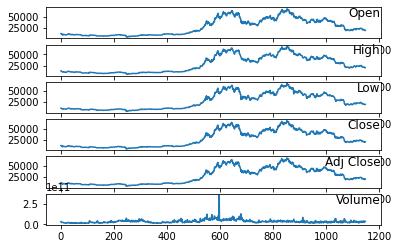

In [ ]:
# path="/content/drive/MyDrive/ETH-USD.csv"
dataset = data
values = dataset.values
n_values=len(values)
print(n_values)
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
#load dataset
#dataset = read_csv(path, header=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.121012   0.122880   0.404181   0.114795   0.114795   0.065334  0.114108   
2   0.114108   0.107359   0.365854   0.102049   0.102049   0.050512  0.101551   
3   0.101551   0.103591   0.366725   0.109355   0.109355   0.035607  0.108887   
4   0.108887   0.102590   0.358014   0.102588   0.102588   0.028267  0.101978   
5   0.101978   0.096432   0.318815   0.084435   0.084435   0.032518  0.084021   

    var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1  0.107359  0.365854  0.102049  0.102049  0.050512  
2  0.103591  0.366725  0.109355  0.109355  0.035607  
3  0.102590  0.358014  0.102588  0.102588  0.028267  
4  0.096432  0.318815  0.084435  0.084435  0.032518  
5  0.090153  0.292683  0.094643  0.094643  0.041054  


In [ ]:
# scaler=MinMaxScaler(feature_range=(0,1))
# values=scaler.fit_transform(values)

In [ ]:
# split into train and test sets
values = reframed.values
random.shuffle(values)
n_train =int(0.9*(n_values)) 
#sklearn.model_selection.train_test_split(values, train_size=n_train, test_size=16000)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, (0,1,2,3,5)], train[:, 4]
test_X, test_y = test[:, (0,1,2,3,5)], test[:, 4]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1034, 1, 5) (1034,) (114, 1, 5) (114,)


Epoch 1/170
33/33 - 5s - loss: 0.0288 - val_loss: 0.1475 - 5s/epoch - 159ms/step
Epoch 2/170
33/33 - 0s - loss: 0.0124 - val_loss: 0.1327 - 173ms/epoch - 5ms/step
Epoch 3/170
33/33 - 0s - loss: 0.0075 - val_loss: 0.1222 - 151ms/epoch - 5ms/step
Epoch 4/170
33/33 - 0s - loss: 0.0045 - val_loss: 0.1133 - 155ms/epoch - 5ms/step
Epoch 5/170
33/33 - 0s - loss: 0.0025 - val_loss: 0.1057 - 170ms/epoch - 5ms/step
Epoch 6/170
33/33 - 0s - loss: 0.0022 - val_loss: 0.0983 - 152ms/epoch - 5ms/step
Epoch 7/170
33/33 - 0s - loss: 0.0016 - val_loss: 0.0921 - 163ms/epoch - 5ms/step
Epoch 8/170
33/33 - 0s - loss: 0.0015 - val_loss: 0.0884 - 159ms/epoch - 5ms/step
Epoch 9/170
33/33 - 0s - loss: 0.0018 - val_loss: 0.0812 - 171ms/epoch - 5ms/step
Epoch 10/170
33/33 - 0s - loss: 0.0011 - val_loss: 0.0807 - 152ms/epoch - 5ms/step
Epoch 11/170
33/33 - 0s - loss: 0.0011 - val_loss: 0.0760 - 171ms/epoch - 5ms/step
Epoch 12/170
33/33 - 0s - loss: 0.0014 - val_loss: 0.0710 - 163ms/epoch - 5ms/step
Epoch 13/170
3

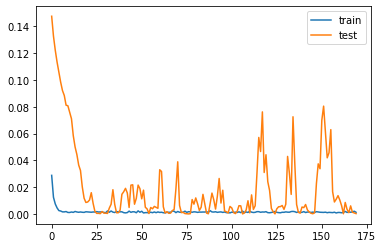

In [ ]:
# design network
model = Sequential()
model.add(GRU(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences = True))
model.add(GRU(40))
model.add(Dense(1))
model.add(BatchNormalization())
model.compile(loss='mse', optimizer='adam')
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# fit network
history = model.fit(train_X, train_y, epochs=170, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

[[ 5.1711679e-02]
 [ 7.1871090e-01]
 [ 8.4837556e-02]
 [ 5.8411193e-01]
 [ 1.6382933e-01]
 [ 6.1317563e-02]
 [ 4.4762766e-01]
 [ 6.9058657e-02]
 [ 4.5440435e-02]
 [ 3.8192248e-01]
 [ 7.9289079e-02]
 [ 8.0803370e-01]
 [ 7.1070671e-02]
 [ 6.8758273e-01]
 [ 6.5881681e-01]
 [ 5.1416039e-02]
 [ 7.1768594e-01]
 [ 5.4042745e-01]
 [ 8.4876633e-01]
 [ 2.7235150e-02]
 [ 5.6941628e-02]
 [ 9.1033816e-02]
 [ 9.4784856e-02]
 [ 6.7792916e-01]
 [ 4.4624865e-01]
 [ 5.9628963e-01]
 [ 5.5872440e-02]
 [ 5.5621982e-02]
 [ 7.6421976e-01]
 [ 8.2272148e-01]
 [ 4.3702006e-02]
 [ 7.8327584e-01]
 [ 1.4794183e-01]
 [ 4.6518719e-01]
 [ 7.1013212e-02]
 [ 4.1656756e-01]
 [ 5.5935860e-02]
 [ 5.0922680e-01]
 [ 6.2888265e-02]
 [ 2.1302819e-02]
 [ 7.0559144e-02]
 [ 5.0894272e-01]
 [ 5.1424026e-02]
 [ 6.9523454e-02]
 [ 3.1789541e-03]
 [ 6.9058657e-02]
 [ 4.2221355e-01]
 [ 4.0572953e-01]
 [ 6.9492626e-01]
 [ 6.5882277e-01]
 [ 5.1042938e-01]
 [-2.1910667e-04]
 [ 2.4093139e-01]
 [ 5.7921290e-02]
 [ 6.4606476e-01]
 [ 8.56249

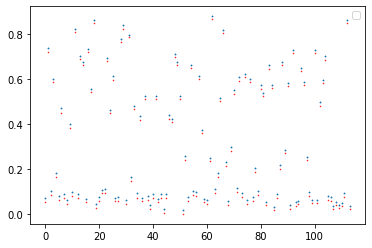

Test RMSE: 0.016


In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# # calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#pyplot.plot(test_y)
#pyplot.plot(yhat)
pyplot.scatter(numpy.arange(len(test_y)), test_y, marker='*',s=1)
pyplot.scatter(numpy.arange(len(test_y)), yhat, marker='.',s=1, color="red")
print(yhat)
path2="/content/drive/MyDrive/output3.csv"
path3="/content/drive/MyDrive/y_real.csv"
numpy.savetxt(path2, yhat)
numpy.savetxt(path3, test_y)
#yhat.to_csv('output2.csv')
#yhat.to_csv(brandname + 'yhat.csv', sep='\t')
#files.download(brandname + 'yhat.csv')
pyplot.legend()
pyplot.show()
print('Test RMSE: %.3f' % rmse)

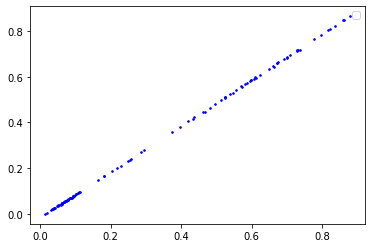

In [ ]:
pyplot.scatter(test_y, yhat, color='blue', marker='.', s=10)
pyplot.legend()
pyplot.show()
